Synthesize Criteo data using sequential CART models. (Note that this file uses the updated synthesis and optimization functions from the `helper_functions.py` file.).

In [1]:
import matplotlib.pyplot as plt
import sys

# Add the parent directory to path
sys.path.append('..')

# Then import
from helper_functions import *

rng = np.random.RandomState(42)

Import Criteo data (small version for testing)

In [3]:
train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo_train.gz",
                         compression='gzip', 
                         sep='\,',
                         header=0,
                         engine='python')
data_set = "train"

View confidential data to synthesize.

In [4]:
train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,14.718064,11.739167,8.547648,-1.860244,10.280525,1.128518,-14.564080,7.603301,3.859290,25.954644,5.300375,-0.168679,1,0,0,0
1,21.780237,10.059654,8.526976,4.679882,10.280525,2.230907,-7.822229,9.687508,3.955396,16.226044,5.300375,-0.168679,1,0,0,0
2,25.851825,10.059654,8.214383,4.679882,10.280525,4.115453,-7.011752,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3,24.742052,10.059654,8.214383,4.679882,10.280525,4.115453,-5.116672,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
4,24.527053,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989791,25.326163,10.059654,8.547430,4.679882,10.280525,4.115453,-2.411115,4.833815,3.915574,23.570168,5.300375,-0.168679,1,0,0,0
6989792,12.616365,10.059654,8.406119,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,16.226044,5.300375,-0.168679,0,0,0,0
6989793,26.170681,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
6989794,23.624754,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


Set up dictionary of parameter bounds for the Bayesian optimization process. The current state of the code requires a set of bounds for each parameter being optimized.

In [5]:
# define some default bounds for leaf values. These will be appropriately filled in during the loop below

param_bounds = {
    'tree': {
        'f0': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f1': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f2': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f3': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f4': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f5': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f6': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f7': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f8': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [4063, 10000]  # [min, max] bounds
        },
        'f9': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f10': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f11': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        }
    }
}

In [6]:
min_bound = 7500

synthesis_cols, synthesis_steps, synthesis_bounds = define_synthesis_steps(train_data = train_data, 
                                                                           current_param_bounds=param_bounds,
                                                                           lower_bound=min_bound)

In [7]:
synthesis_cols

['treatment',
 'exposure',
 'visit',
 'conversion',
 'f8',
 'f9',
 'f4',
 'f3',
 'f5',
 'f6',
 'f11',
 'f10',
 'f0',
 'f1',
 'f7',
 'f2']

In [8]:
synthesis_steps

[(['treatment', 'exposure', 'visit', 'conversion'], 'joint_categorical'),
 (['f8', 'f9', 'f4', 'f3', 'f5', 'f6', 'f11', 'f10', 'f0', 'f1', 'f7', 'f2'],
  'tree')]

In [9]:
synthesis_bounds

{'tree': {'f0': {'min_samples_leaf': [7500, 3494898]},
  'f1': {'min_samples_leaf': [7500, 7500]},
  'f2': {'min_samples_leaf': [7500, 7500]},
  'f3': {'min_samples_leaf': [7500, 3494898]},
  'f4': {'min_samples_leaf': [7500, 7500]},
  'f5': {'min_samples_leaf': [7500, 3494898]},
  'f6': {'min_samples_leaf': [7500, 3494898]},
  'f7': {'min_samples_leaf': [7500, 3494898]},
  'f8': {'min_samples_leaf': [7500, 3494898]},
  'f9': {'min_samples_leaf': [7500, 3494898]},
  'f10': {'min_samples_leaf': [7500, 7500]},
  'f11': {'min_samples_leaf': [7500, 3494898]}}}

Define additional parameters of the optimization process:

- num_synthetic_datasets: Number of synthetic datasets to generate on each iteration of the optimizer (usually use 10 to reduce compute time)
- num_iter_optimization: Number of iterations to run the optimizer (default is 25, can run longer to try to find a better solution)
- num_init_optimization: Number of initializations to perform prior to optimized iterations (usually 3-5, this just starts the optimizer)
- random_states: run the optimizer all the way through for each random seed in this list

In [10]:
number_synthetic_datasets = 10
num_iter_optimization = 25
num_init_optimization = 5
random_states = [1006, 428]

Compute target parameters.

In [11]:
# reorder the columns in the training data to match the synthesis order
train_data = train_data[synthesis_cols]

In [12]:
train_data

,treatment,exposure,visit,conversion,f8,f9,f4,f3,f5,f6,f11,f10,f0,f1,f7,f2
0,1,0,0,0,3.859290,25.954644,10.280525,-1.860244,1.128518,-14.564080,-0.168679,5.300375,14.718064,11.739167,7.603301,8.547648
1,1,0,0,0,3.955396,16.226044,10.280525,4.679882,2.230907,-7.822229,-0.168679,5.300375,21.780237,10.059654,9.687508,8.526976
2,1,0,0,0,3.971858,13.190056,10.280525,4.679882,4.115453,-7.011752,-0.168679,5.300375,25.851825,10.059654,4.833815,8.214383
3,1,0,0,0,3.971858,13.190056,10.280525,4.679882,4.115453,-5.116672,-0.168679,5.300375,24.742052,10.059654,4.833815,8.214383
4,1,0,0,0,3.971858,13.190056,10.280525,4.679882,4.115453,-1.288207,-0.168679,5.300375,24.527053,10.059654,4.833815,8.214383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989791,1,0,0,0,3.915574,23.570168,10.280525,4.679882,4.115453,-2.411115,-0.168679,5.300375,25.326163,10.059654,4.833815,8.547430
6989792,0,0,0,0,3.955396,16.226044,10.280525,4.679882,4.115453,0.294443,-0.168679,5.300375,12.616365,10.059654,4.833815,8.406119
6989793,1,0,0,0,3.971858,13.190056,10.280525,4.679882,4.115453,-3.993764,-0.168679,5.300375,26.170681,10.059654,4.833815,8.214383
6989794,1,0,0,0,3.971858,13.190056,10.280525,4.679882,4.115453,-2.411115,-0.168679,5.300375,23.624754,10.059654,4.833815,8.214383


In [13]:
target_variable = 'conversion'
exog_variables = list(train_data.drop(target_variable, axis=1).columns)

In [14]:
target_params = logit_params(X = train_data[exog_variables], y = train_data[target_variable])

In [15]:
target_params

intercept   -0.176053
treatment   -0.555496
exposure     1.503068
visit        7.446032
f8          -0.631709
f9          -0.011792
f4           0.759987
f3          -0.072159
f5          -0.145088
f6           0.033332
f11         -0.617136
f10          0.189011
f0           0.010371
f1          -0.730233
f7          -0.047554
f2          -1.016528
dtype: float64

Use the `optimization_models` function to perform the optimized synthesis process. The function returns the objective value associated with each iteration, the best set of parameters for each random seed, and the final optimization object from the Bayesian optimization function.

In [16]:
# import warnings
# warnings.filterwarnings('ignore')

# we are silencing harmless overflow warnings from numpy related to the Yeo-johnson transformation
# these warnings are not related to the optimization process and can be safely ignored

optimization_results = [optimize_models_with_param_target(train_data=train_data,
                                                          number_synthetic_datasets=number_synthetic_datasets,
                                                          synthesis_steps=synthesis_steps,
                                                          param_bounds=synthesis_bounds,
                                                          random_state=r,
                                                          target_params=target_params,
                                                          target_variable=target_variable,
                                                          exog_variables=exog_variables,
                                                          n_iter=num_iter_optimization,
                                                          n_init=num_init_optimization) for r in random_states]

Optimizing 12 parameters: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
|   iter    |  target   |    x0     |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |    x9     |    x10    |    x11    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.818629 | 2599080.8 | 7500.0    | 7500.0    | 3084624.6 | 7500.0    | 2522833.0 | 1037495.4 | 1840184.7 | 613486.05 | 2839124.9 | 7500.0    | 902087.81 |
| 2         | -0.799661 | 834830.94 | 7500.0    | 7500.0    | 711991.15 | 7500.0    | 3427690.8 | 2570053.5 | 1434909.4 | 2165540.9 | 283795.40 | 7500.0    | 2118844.0 |
| 3         | -0.711875 | 1578527.5 | 7500.0    | 7500.0    | 1015450.9 | 7500.0    | 2855929.1 | 931764.26 | 1256153.8 | 2342960.4 | 3235736.2 | 7500.0    | 2923570.1 |
| 4         | -0.799132 | 718067.50 | 7500.0    |

In [17]:
run_targets = [np.minimum.accumulate(-i['optimizer'].space.target) for i in optimization_results]

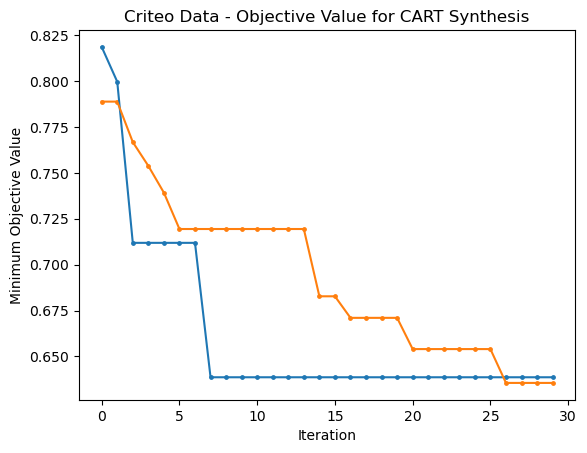

In [18]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Criteo Data - Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

In [19]:
optimization_results

[{'best_params': {'gmm': {},
   'multinomial': {},
   'tree': {'f8': {'min_samples_leaf': np.float64(923890.5020314858)},
    'f9': {'min_samples_leaf': np.float64(7500.0)},
    'f4': {'min_samples_leaf': np.float64(7500.0)},
    'f3': {'min_samples_leaf': np.float64(2058271.2122799873)},
    'f5': {'min_samples_leaf': np.float64(7500.0)},
    'f6': {'min_samples_leaf': np.float64(2879955.180891439)},
    'f11': {'min_samples_leaf': np.float64(174097.91488904302)},
    'f10': {'min_samples_leaf': np.float64(281514.7764068233)},
    'f0': {'min_samples_leaf': np.float64(2497393.0824396596)},
    'f1': {'min_samples_leaf': np.float64(1068850.5414116574)},
    'f7': {'min_samples_leaf': np.float64(7500.0)},
    'f2': {'min_samples_leaf': np.float64(3216311.972265982)}}},
  'best_score': np.float64(0.6386369516695118),
  'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization at 0x2bda8de6720>},
 {'best_params': {'gmm': {},
   'multinomial': {},
   'tree': {'f8': {'min_samples_l

In [20]:
best_params = optimization_results[np.argmin([x['best_score'] for x in optimization_results])]['best_params']

In [21]:
best_state = random_states[np.argmin([x['best_score'] for x in optimization_results])]

In [22]:
# warnings.filterwarnings('ignore')

# again, we are silencing harmless overflow warnings from numpy related to the Yeo-johnson transformation

sds, full_sXs = perform_synthesis_with_param_target(
    train_data=train_data,
    number_synthetic_datasets=20,
    synthesis_steps=synthesis_steps,
    target_params=target_params,
    target_variable=target_variable,
    exog_variables=exog_variables,
    param_values=best_params,
    random_state=best_state
)

In [23]:
np.mean(sds)

np.float64(0.7356474691892343)

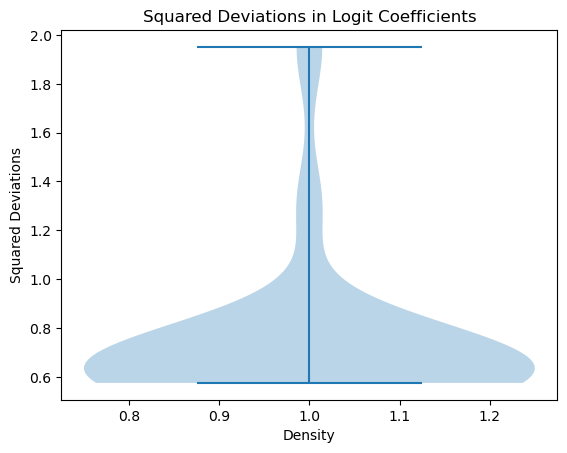

In [24]:
plt.violinplot(sds)
plt.xlabel("Density")
plt.ylabel("Squared Deviations")
plt.title("Squared Deviations in Logit Coefficients")
plt.show()

In [25]:
synthetic_data_path = "../../Data/Criteo/"

for i, sX in enumerate(full_sXs):
    if not os.path.exists(synthetic_data_path):
        os.makedirs(synthetic_data_path)
    sX.to_csv(synthetic_data_path + "cart_" + str(i) + "_" + data_set + ".csv", index=False)

End of file.